In [1]:
import torch
import pandas as pd
import warnings
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
warnings.filterwarnings('ignore')
import os

In [2]:
os.getcwd()

'E:\\My_Career\\Projects\\ML_stock_market'

In [3]:
preprocess_data = ".\data\preprocessed"

In [4]:
train = pd.read_csv(f"{preprocess_data}\\train.csv")
test = pd.read_csv(f"{preprocess_data}\\test.csv")
val = pd.read_csv(f"{preprocess_data}\\val.csv")
print("Train :", train.shape)
print("Val :", val.shape)
print("Test :", test.shape)

Train : (105856, 11)
Val : (19824, 11)
Test : (13080, 11)


In [5]:
test.head()

,Close,EMA_10,EMA_20,EMA_50,RSI_14,BB_BW_20,OBV,STOCH_K,STOCH_D,Date,Ticker
0,2.288578,2.203565,2.216519,2.206015,0.391363,-0.423680,1.296985,1.275350,0.863917,2024-04-01,ADANIENT.NS
1,2.303678,2.223475,2.226722,2.211911,0.470701,-0.432754,1.297450,1.404841,1.316769,2024-04-02,ADANIENT.NS
2,2.271664,2.233927,2.232884,2.216298,0.225584,-0.456557,1.296833,1.130305,1.347710,2024-04-03,ADANIENT.NS
3,2.251124,2.238732,2.236491,2.219695,0.072292,-0.490593,1.296083,0.908491,1.217927,2024-04-04,ADANIENT.NS
4,2.263820,2.244979,2.240971,2.223465,0.153833,-0.528333,1.296487,0.855262,1.023504,2024-04-05,ADANIENT.NS


In [6]:
val.head()

,Close,EMA_10,EMA_20,EMA_50,RSI_14,BB_BW_20,OBV,STOCH_K,STOCH_D,Date,Ticker
0,0.826834,0.849660,0.882867,0.915896,-0.651191,-0.319398,1.113181,-0.465499,-0.583041,2022-03-02,ADANIENT.NS
1,0.828646,0.846747,0.878713,0.913564,-0.634837,-0.328855,1.113894,-0.252794,-0.407616,2022-03-03,ADANIENT.NS
2,0.802552,0.839606,0.872453,0.910282,-0.820770,-0.294521,1.113128,-0.652965,-0.485427,2022-03-04,ADANIENT.NS
3,0.756389,0.825345,0.862365,0.905289,-1.119465,-0.211860,1.112321,-1.360907,-0.802194,2022-03-07,ADANIENT.NS
4,0.790411,0.819881,0.856498,0.901848,-0.785146,-0.213497,1.113068,-0.839156,-1.009630,2022-03-08,ADANIENT.NS


In [7]:
features = ['Close', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI_14', 'BB_BW_20', 'OBV', 'STOCH_K', 'STOCH_D']

In [8]:
def create_sequences_direction(df, lookback=60, horizon=15, feature_cols=None, target_col="Close", threshold=0.0):
    X, y = [], []
    df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    
    for ticker, group in df.groupby("Ticker"):
        group = group.reset_index(drop=True)
        if len(group) < lookback + horizon:
            continue

        features = group[feature_cols].values
        close_prices = group[target_col].values

        for i in range(len(group) - lookback - horizon + 1):
            x_seq = features[i : i + lookback]
            
            price_now = close_prices[i + lookback - 1]
            price_future = close_prices[i + lookback + horizon - 1]

            future_return = (price_future - price_now) / price_now

            # Label: 1 if price goes up by at least `threshold`, else 0
            direction = 1 if future_return >= threshold else 0

            X.append(x_seq)
            y.append(direction)

    return np.array(X), np.array(y)

In [9]:
X_tr, y_tr = create_sequences_direction(train, lookback=60, horizon=30, feature_cols=features, target_col="Close", threshold=0.01)
print(X_tr[0])
print(y_tr[0])

[[-0.60533345 -0.6040499  -0.6032071  -0.60192451 -0.39123772 -0.6385932
  -1.42167753  0.52247469  0.60603132]
 [-0.60552321 -0.6041861  -0.60328589 -0.60192577 -0.4578044  -0.7052657
  -1.4220411   0.46046687  0.60337298]
 [-0.6055117  -0.60429543 -0.60335608 -0.60192652 -0.45289856 -0.71890976
  -1.42154981  0.46422574  0.511641  ]
 [-0.60716776 -0.60468689 -0.60357831 -0.60199328 -1.00243801 -0.6519235
  -1.42255205 -1.0493434  -0.04441764]
 [-0.60728276 -0.60502814 -0.60379039 -0.60206201 -1.03620882 -0.6020805
  -1.4228635  -1.1089197  -0.59961608]
 [-0.60662725 -0.60518781 -0.60391945 -0.6021019  -0.72865563 -0.58832548
  -1.42237186 -0.76931744 -1.03600394]
 [-0.60624198 -0.60524819 -0.60399929 -0.60212486 -0.55551379 -0.58393847
  -1.42210332 -0.56972136 -0.8663291 ]
 [-0.60650075 -0.60534478 -0.60409633 -0.60215725 -0.65083011 -0.56793512
  -1.42311518 -0.63860232 -0.69994595]
 [-0.60621898 -0.60537242 -0.60415712 -0.60217712 -0.51589013 -0.56383527
  -1.42199319 -0.43770703 

In [10]:
X_tr.shape, y_tr.shape

((101584, 60, 9), (101584,))

In [11]:
X_v, y_v = create_sequences_direction(val, lookback=60, horizon=30, feature_cols=features, target_col="Close", threshold=0.01)
print(X_v[0])
print(y_v[0])

[[ 8.26834392e-01  8.49659619e-01  8.82867316e-01  9.15895798e-01
  -6.51191289e-01 -3.19397705e-01  1.11318128e+00 -4.65498853e-01
  -5.83040568e-01]
 [ 8.28646400e-01  8.46747458e-01  8.78712670e-01  9.13563564e-01
  -6.34837025e-01 -3.28854553e-01  1.11389385e+00 -2.52794287e-01
  -4.07615578e-01]
 [ 8.02552068e-01  8.39606224e-01  8.72452746e-01  9.10282209e-01
  -8.20770294e-01 -2.94520652e-01  1.11312775e+00 -6.52965451e-01
  -4.85427342e-01]
 [ 7.56388693e-01  8.25345053e-01  8.62364572e-01  9.05288644e-01
  -1.11946513e+00 -2.11859526e-01  1.11232138e+00 -1.36090660e+00
  -8.02193775e-01]
 [ 7.90410961e-01  8.19881115e-01  8.56497971e-01  9.01847636e-01
  -7.85146045e-01 -2.13496533e-01  1.11306764e+00 -8.39156107e-01
  -1.00962971e+00]
 [ 8.40198684e-01  8.24489899e-01  8.55961896e-01  9.00526988e-01
  -3.49794450e-01 -2.47009203e-01  1.11386831e+00  3.09319042e-02
  -7.67688843e-01]
 [ 9.18390930e-01  8.42519844e-01  8.62971051e-01  9.02376259e-01
   2.08014857e-01 -3.1919359

In [12]:
X_v.shape, y_v.shape

((15552, 60, 9), (15552,))

In [13]:
X_t, y_t = create_sequences_direction(test, lookback=60, horizon=30, feature_cols=features, target_col="Close", threshold=0.01)
print(X_t[0])
print(y_t[0])

[[ 2.28857805e+00  2.20356538e+00  2.21651947e+00  2.20601479e+00
   3.91363146e-01 -4.23680382e-01  1.29698525e+00  1.27535030e+00
   8.63917183e-01]
 [ 2.30367778e+00  2.22347494e+00  2.22672169e+00  2.21191052e+00
   4.70701125e-01 -4.32753915e-01  1.29744958e+00  1.40484072e+00
   1.31676885e+00]
 [ 2.27166442e+00  2.23392663e+00  2.23288402e+00  2.21629842e+00
   2.25584043e-01 -4.56556805e-01  1.29683332e+00  1.13030453e+00
   1.34771043e+00]
 [ 2.25112368e+00  2.23873220e+00  2.23649077e+00  2.21969513e+00
   7.22916819e-02 -4.90593353e-01  1.29608307e+00  9.08490716e-01
   1.21792732e+00]
 [ 2.26381981e+00  2.24497930e+00  2.24097086e+00  2.22346493e+00
   1.53833122e-01 -5.28333475e-01  1.29648689e+00  8.55262273e-01
   1.02350417e+00]
 [ 2.26359332e+00  2.25004926e+00  2.24500256e+00  2.22707786e+00
   1.51957800e-01 -5.31088934e-01  1.29617829e+00  8.52545540e-01
   9.25241979e-01]
 [ 2.23992342e+00  2.24988097e+00  2.24638170e+00  2.22960521e+00
  -4.81188313e-02 -5.3348602

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (samples, lookback, features)
        self.y = torch.tensor(y, dtype=torch.long)      # For classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
train_ds = TimeSeriesDataset(X_tr, y_tr)
val_ds = TimeSeriesDataset(X_v, y_v)
test_ds = TimeSeriesDataset(X_t, y_t)

In [16]:
# create dataloaders for each dataset
train_dataset = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_dataset = DataLoader(dataset=test_ds, batch_size=32, shuffle=True)
val_dataset = DataLoader(dataset=val_ds, batch_size=32, shuffle=True)

In [17]:
from model import *

In [18]:
model = build_transformer(input_dim=9, output_dim=2, src_seq_len=60, tgt_seq_len=10, d_model=16, N=2, h=4, dropout=0.2, d_ff=16)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
np.unique(y_tr[:], return_counts=True)

(array([0, 1]), array([64969, 36615], dtype=int64))

In [21]:
train_ds.X.shape

torch.Size([101584, 60, 9])

In [20]:
class_counts = torch.tensor([64969, 36615], dtype=torch.float32)
weights = 1.0 / class_counts
weights = weights / weights.sum()

In [23]:
print(weights)

tensor([0.3604, 0.6396])


In [22]:
#criterion = nn.CrossEntropyLoss(weight=weights.to(device))
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=10e-3)

In [24]:
os.makedirs("./model_artefacts") ## if not exists

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './model_artefacts'

In [23]:
model_dir = "./model_artefacts"

In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt


In [44]:
def train_model_with_early_stopping_f1(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, model_path):
    
    best_val_fbeta = 0.0
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    val_fbeta = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0
        all_train_preds = []
        all_train_targets = []

        for enc_input, target in train_loader:
            enc_input = enc_input.to(device).float()
            #dec_input = dec_input.to(device).float()
            target = target.to(device).long()  # important for classification

            optimizer.zero_grad()
            output = model(enc_input, None, enc_input[:, -10:, :], None)
            output = output[:, -1, :]  # shape: [batch_size, num_classes]

            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(target.cpu().numpy())

        avg_train_loss = running_train_loss / len(train_loader)
        #train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')  # or 'weighted'

        train_losses.append(avg_train_loss)
        #train_f1s.append(train_f1)

        # Validation
        model.eval()
        running_val_loss = 0
        all_val_preds = []
        all_val_targets = []

        with torch.no_grad():
            for enc_input, target in val_loader:
                enc_input = enc_input.to(device).float()
                #dec_input = dec_input.to(device).float()
                target = target.to(device).long()

                output = model(enc_input, None, enc_input[:, -10:, :], None)
                output = output[:, -1, :]  # shape: [batch_size, num_classes]

                loss = criterion(output, target)
                running_val_loss += loss.item()

                preds = torch.argmax(output, dim=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(target.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        #val_f1 = f1_score(all_val_targets, all_val_preds, average='macro')
        val_precision = precision_score(all_val_targets, all_val_preds)
        val_recall = recall_score(all_val_targets, all_val_preds)
        val_losses.append(avg_val_loss)
       
        fbeta = fbeta_score(all_val_targets, all_val_preds, average='weighted', beta=0.5)
        val_fbeta.append(fbeta)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | f_beta: {fbeta:.4f}")

        # Early stopping based on F1
        if fbeta > best_val_fbeta:
            best_val_fbeta = fbeta
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}.")
                break

    print(f"\nBest model saved with validation F1: {best_val_fbeta:.4f}")

    # Plot
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    # plt.plot(train_f1s, label="Train F1")
    # plt.plot(val_f1s, label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/30] | Train Loss: 0.6384 | Val Loss: 0.6819 | Val Precision: 0.5994 | Val Recall: 0.9247 | f_beta: 0.4733
Epoch [2/30] | Train Loss: 0.6382 | Val Loss: 0.7051 | Val Precision: 0.7639 | Val Recall: 0.0250 | f_beta: 0.2500
Epoch [3/30] | Train Loss: 0.6381 | Val Loss: 0.6887 | Val Precision: 0.5920 | Val Recall: 0.8269 | f_beta: 0.4891
Epoch [4/30] | Train Loss: 0.6383 | Val Loss: 0.6744 | Val Precision: 0.6055 | Val Recall: 0.9661 | f_beta: 0.4745
Epoch [5/30] | Train Loss: 0.6392 | Val Loss: 0.6837 | Val Precision: 0.5959 | Val Recall: 0.8752 | f_beta: 0.4844
Epoch [6/30] | Train Loss: 0.6385 | Val Loss: 0.6740 | Val Precision: 0.6050 | Val Recall: 0.9712 | f_beta: 0.4680
Epoch [7/30] | Train Loss: 0.6390 | Val Loss: 0.6784 | Val Precision: 0.6037 | Val Recall: 0.9275 | f_beta: 0.4896
Epoch [8/30] | Train Loss: 0.6394 | Val Loss: 0.6740 | Val Precision: 0.6045 | Val Recall: 0.9648 | f_beta: 0.4702
Epoch [9/30] | Train Loss: 0.6395 | Val Loss: 0.7336 | Val Precision: 0.0000 | V

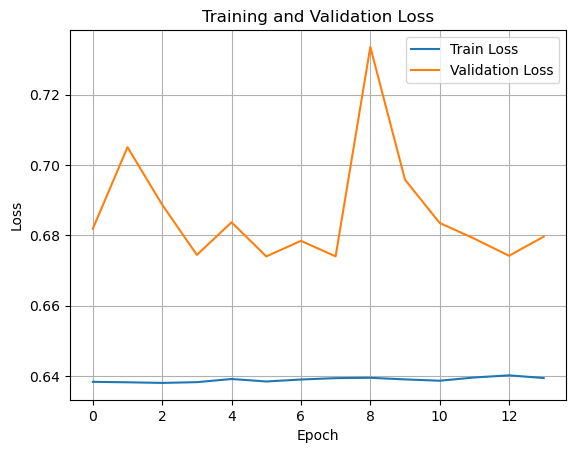

In [45]:
train_model_with_early_stopping_f1(
   model=model,
   train_loader=train_dataset,
   val_loader=val_dataset,
   criterion=criterion,
   optimizer=opt,
   num_epochs=30,
   device=device,
   patience=4,
   model_path=f'{model_dir}//best_model.pt')

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [47]:
model.load_state_dict(torch.load(f'{model_dir}//best_model.pt'))
model = model.to(device)
model.eval()

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=16, out_features=16, bias=True)
          (w_k): Linear(in_features=16, out_features=16, bias=True)
          (w_v): Linear(in_features=16, out_features=16, bias=True)
          (w_o): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (W1): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (W2): Linear(in_features=16, out_features=16, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.2, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization()
  )
  (decoder): Decoder(
 

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Example after epoch
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for enc_input, target in test_dataset:
        enc_input = enc_input.to(device).float()
        #dec_input = dec_input.to(device).float()
        target = target.to(device).long()
        output = model(enc_input, None, enc_input[:, -10:, :], None)
        output = output[:, -1, :]
        preds = torch.argmax(output, dim=1)
        y_true_all.extend(target.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

precision = precision_score(y_true_all, y_pred_all, average='weighted')
recall = recall_score(y_true_all, y_pred_all, average='weighted')
f1 = fbeta_score(y_true_all, y_pred_all, average='weighted', beta=0.5)
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

Precision: 0.497 | Recall: 0.487 | F1: 0.493


In [50]:
print("Unique predicted labels:", np.unique(y_pred_all,return_counts=True))

Unique predicted labels: (array([0, 1], dtype=int64), array([4240, 4479], dtype=int64))


In [51]:
print("Unique target labels:", np.unique(y_true_all,return_counts=True))

Unique target labels: (array([0, 1], dtype=int64), array([4925, 3794], dtype=int64))
